# Visually Comparing Climate Models



---
### Summary

In this notebook, I will be comparing three climate reanalysis models:

* NCEP-DOE Reanalysis 2: Surface
* ERA5
* CMIP5

I will be looking at the following variables:

* Mean Sea Level Pressure (CMIP5, ERA5, NCEP)
* Surface Pressure (ERA5, NCEP)

I will be trying to user RBIG in order to assess how similar these models are. I'll be looking at the following IT measures. If these climate models are that similar, then they should exhibit similar IT measures.

---
### Preprocessing Steps

**Regridded Spatially**

* The ERA5 had the coarsest spatial resolution (2.5 x 2.5). 
* I regridded the NCEP from (0.25 x 0.25) to (2.5 x 2.5).
* I regridded the CMIP5 from (2 x 2.5) to (2.5 x 2.5).

**Temporal Resolution**

* ERA5 and NCEP go from 1980-2019
* CMIP5 goes from 2006-2018
* For comparing ERA5 vs CMIP5 and NCEP vs CMIPF, I found the same time components


---
### Measures

I'm measuring the following:

* Entropy - expected uncertainty
* Total Correlation - amount of redundant information between features
* Mutual Information - amount of information shared between variables


---
### Data

**Inputs**

I'm taking each year as is. Each spatial location is a sample and each year is a feature. My inputs are:

$$X \in \mathbb{R}^{\text{spatial } \times \text{ month}}$$

**Outputs**

All my information theory measures are in nats. They are scalars.

---
### Hypothesis

Simple: The ERA5 and the NCEP model should be more similar than the CMIP5 model compared to each of them. 

---
## Data - Climate Models

In [2]:
import os, sys
cwd = os.getcwd()
source_path = f"{cwd}/../../../"
sys.path.insert(0, f'{source_path}')


# ESDC tools
sys.path.insert(0, f'/home/emmanuel/code/py_esdc')
# from esdc.preprocessing import normalize_temporal

import cdsapi
from zipfile import ZipFile
import pandas as pd
import xarray as xr
from tqdm import tqdm
from sklearn import preprocessing

# Visualization Tools
from src.data.climate.loader import ResultsLoader
# from src.visualization.climate import PlotResults

import seaborn as sns
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
plt.style.use(['seaborn-notebook', 'fivethirtyeight'])

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
data_path = f"/home/emmanuel/projects/2020_rbig_rs/data/climate/raw/"
results_path = f"/home/emmanuel/projects/2020_rbig_rs/data/climate/results/amip/"
fig_path = f"/home/emmanuel/projects/2020_rbig_rs/reports/figures/climate/"

## Experiment II - Global

In [54]:
from pathlib import Path
data_path = f"/home/emmanuel/projects/projects/2020_rbig_rs/data/climate/results/amip/local/compare/"

def get_results_files(base_model: str, trials: bool)-> pd.DataFrame:
    
    path = Path(data_path)
    
    if base_model == 'ncep':
        base_pattern = 'ncep'
        
    elif base_model == 'era5':
        base_pattern = 'era5'
        
    else:
        raise ValueError('Unrecognized base model:', base_model)
    
    if trials == True:
        trials_ext = 'v1'
    elif trials == False:
        trials_ext = 'v2'
    else:
        raise ValueError("Unrecognized trials extentions:", trials)
    
    filename_pattern = base_pattern + '*' + trials_ext + '.csv'
    
    df_from_each_file = [pd.read_csv(f, index_col=0) for f in path.rglob(filename_pattern)]
    results_df   = pd.concat(df_from_each_file, ignore_index=True)
    return results_df

def post_processing_compare(df: pd.DataFrame)-> pd.DataFrame:
    
    # divide by the spatial resolution
    df['mi'] = df['mi'] / (df['spatial'] ** 2)
    
    return df

In [24]:
!ls /home/emmanuel/projects/2020_rbig_rs/data/climate/results/amip/

compare_trial_v1.csv	      spatial_compare_v3.csv
global			      spatial_compare_v4.csv
global_compare_v2.csv	      spatial_compare_v5.csv
global_compare_v3.csv	      spatial_individual_trial_v1.csv
global_individual_v2.csv      spatial_individual_v2.csv
global_individual_v3.csv      spatial_individual_v3.csv
global_individual_v4.csv      spatial_individual_v4.csv
individual_trial_v1.csv       spatial_individual_v5.csv
local			      spatial_individual_v6.csv
spatial_compare_trial_v1.csv  v1.csv
spatial_compare_v2.csv	      v2.csv


### Entropy

In [64]:
df = pd.read_csv('/home/emmanuel/projects/2020_rbig_rs/data/climate/results/amip/local/compare/ncep_giss_e2_r_v1.csv')
df.head()

,Unnamed: 0,base,base_time,cmip,cmip_time,kendelltau,mi,pearson,spatial,spearman,subsample,time_mi,trial,variable
0,0,ncep,1979-01-01,giss_e2_r,1979-01-16 12:00:00,0.563060,64.134183,0.808342,1.0,0.707243,10000.0,144.201249,0.0,psl
1,1,ncep,1979-01-01,giss_e2_r,1979-01-16 12:00:00,0.544984,48.654250,0.799264,1.0,0.687433,10000.0,143.872942,1.0,psl
2,2,ncep,1979-01-01,giss_e2_r,1979-01-16 12:00:00,0.562437,63.313985,0.804248,1.0,0.707118,10000.0,144.430818,2.0,psl
3,3,ncep,1979-01-01,giss_e2_r,1979-01-16 12:00:00,0.554199,51.324040,0.804323,1.0,0.697068,10000.0,144.311730,3.0,psl
4,4,ncep,1979-01-01,giss_e2_r,1979-01-16 12:00:00,0.562449,54.053800,0.809600,1.0,0.708408,10000.0,144.233112,4.0,psl


In [63]:
data_path = f"/home/emmanuel/projects/2020_rbig_rs/data/climate/results/amip/local/compare/"

results_df = get_results_files('era5', False)
results_df.head()

,base,base_time,cmip,cmip_time,kendelltau,mi,pearson,spatial,spearman,subsample,time_mi,trial,variable
0,era5,1979-02-01,bcc_csm1_1,1979-01-16 12:00:00,0.604009,16.986968,0.780169,1.0,0.771412,50000.0,464.482649,0.0,psl
1,era5,1979-03-01,bcc_csm1_1,1979-02-15 00:00:00,0.554846,2.031379,0.782028,1.0,0.715671,50000.0,27.219500,0.0,psl
2,era5,1979-04-01,bcc_csm1_1,1979-03-16 12:00:00,0.408038,17.362542,0.705173,1.0,0.512198,50000.0,462.325981,0.0,psl
3,era5,1979-05-01,bcc_csm1_1,1979-04-16 00:00:00,0.553775,17.332411,0.846170,1.0,0.721791,50000.0,465.709235,0.0,psl
4,era5,1979-06-01,bcc_csm1_1,1979-05-16 12:00:00,0.448313,17.002557,0.727373,1.0,0.609172,50000.0,465.904498,0.0,psl


In [65]:
def plot_global_entropy(results_df: pd.DataFrame, base: str, cmip: str, normalized=True, log_mi=True)-> None:
    
    if normalized == True:
        results_df['h_cmip'] = results_df['h_cmip'] / results_df['spatial']
        results_df['h_base'] = results_df['h_base'] / results_df['spatial']
    results_df = results_df[results_df['base'] == base]
    results_df = results_df[results_df['cmip'] == cmip]
    sns.scatterplot(data=results_df, x='spatial', y='h_base', label=f"{base}")
    sns.scatterplot(data=results_df, x='spatial', y='h_cmip', label=f"{cmip}")
    plt.title(f'{base.upper()}, CMIP: {cmip.upper()}')
    plt.xlabel('Spatial Features')
    plt.ylabel('Entropy, H')
    plt.legend()
    plt.show()

#### Example

In [66]:
plot_global_entropy(results_df, 'era5', 'inmcm4', normalized=False,)
# plot_global_entropy(results, 'ncep', 'inmcm4', normalized=False)

ValueError: Could not interpret input 'h_base'

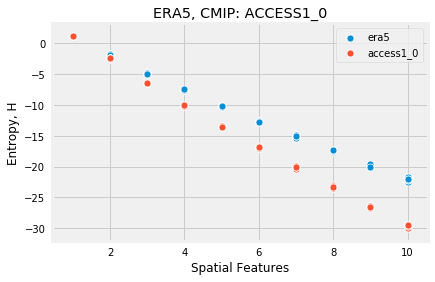

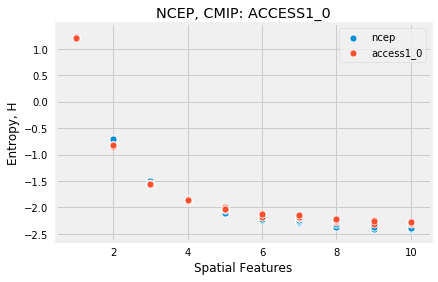

In [9]:
plot_global_entropy(results, 'era5', 'access1_0')
plot_global_entropy(results, 'ncep', 'access1_0')

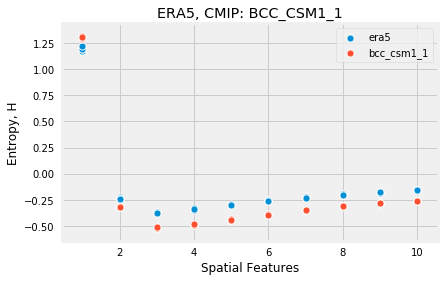

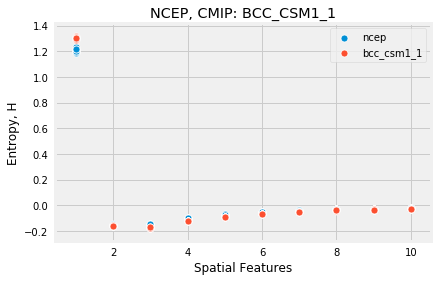

In [10]:
plot_global_entropy(results, 'era5', 'bcc_csm1_1')
plot_global_entropy(results, 'ncep', 'bcc_csm1_1')

### Difference in Entropy

In [9]:
import numpy as np

def plot_global_diff_entropy(results_df: pd.DataFrame, base: str, normalized=True, log_mi=False)-> None:
    
    
    results_copy = results_df[results_df['base'] == base]
    
    # calculate difference
    results_copy['h_diff'] = np.abs(results_copy['h_cmip'] - results_copy['h_base'])
        
    if normalized == True:
        results_copy['h_diff'] = results_copy['h_diff'] / results_copy['spatial']
    if log_mi == True:
        results_copy['h_diff'] = np.log(results_copy['h_diff'])
    
    fig, ax = plt.subplots()
#     sns.scatterplot(ax=ax, data=results_copy, x='spatial', y='h_diff', hue='base', color='black')
    sns.scatterplot(ax=ax, data=results_copy, x='spatial', y='h_diff', hue='cmip')
        
    plt.title(f'')
    plt.xlabel('Spatial Features')
    plt.ylabel('Entropy, H')
    plt.legend(ncol=2, bbox_to_anchor=(2.05, 1), fontsize=16)
#     plt.tight_layout()
    plt.show()

/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


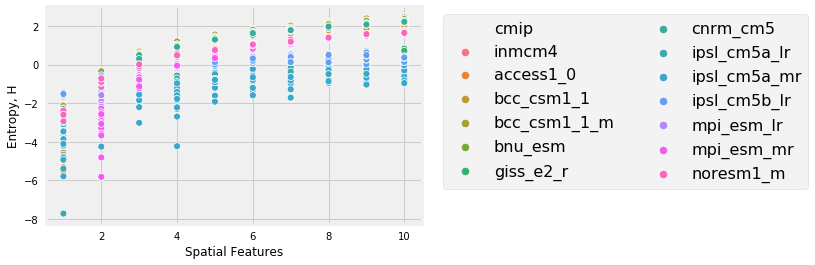

In [10]:
plot_global_diff_entropy(results, 'era5', log_mi=True)

/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


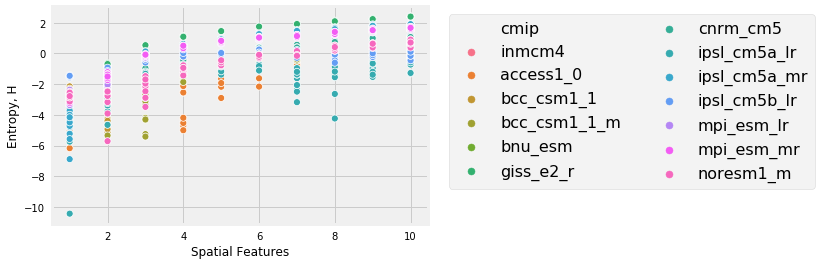

In [11]:
plot_global_diff_entropy(results, 'ncep', log_mi=True)

#### With Trials

In [12]:
results = pd.read_csv(results_path + 'global_individual_v2' + '.csv', index_col=[0])
results.tail()

,base,cmip,h_base,h_cmip,spatial,subsample,t_base,t_cmip,tc_base,tc_cmip,trial,variable
176,era5,inmcm4,-152.856326,-212.159987,8.0,100000.0,1487.383127,3723.010468,229.260819,291.769992,6.0,psl
177,era5,inmcm4,-159.696107,-206.211365,8.0,100000.0,3956.267908,1091.634434,236.318558,285.910037,7.0,psl
178,era5,inmcm4,-160.053642,-209.888019,8.0,100000.0,4081.433451,2519.339015,236.233725,289.423930,8.0,psl
179,era5,inmcm4,-152.323103,-213.647626,8.0,100000.0,1079.461287,4903.696667,228.587248,293.220535,9.0,psl
180,era5,inmcm4,-191.559603,-264.508531,9.0,100000.0,1227.619855,1339.133950,288.171641,365.250712,0.0,psl


In [13]:
def plot_global_entropy(results_df: pd.DataFrame, base: str, cmip: str)-> None:
    results_df = results_df[results_df['base'] == base]
    results_df = results_df[results_df['cmip'] == cmip]
    sns.scatterplot(data=results_df, x='spatial', y='h_base', label=f"{base}")
    sns.scatterplot(data=results_df, x='spatial', y='h_cmip', label=f"{cmip}")
    plt.title(f'{base.upper()}, CMIP: {cmip.upper()}')
    plt.xlabel('Spatial Features')
    plt.ylabel('Entropy, H')
    plt.legend()
    plt.show()

In [14]:

results_ = results[results['base'] == 'ncep']
results_ = results_[results_['cmip'] == 'inmcm4']
results_['h_cmip'] = results_['h_cmip'] / results_['spatial']
results_.groupby(['spatial']).mean()
# results_ = results_[results_['spatial'] == 1.0]
# results_.mean(['trial'])

,h_base,h_cmip,subsample,t_base,t_cmip,tc_base,tc_cmip,trial
spatial,,,,,,,,
1.0,1.224428,1.257564,100000.0,4.880306,5.055687,0.000000,0.000000,4.5
2.0,-3.159978,-1.407663,100000.0,36.307454,41.259031,8.046948,7.841133,4.5
3.0,-16.086698,-4.510076,100000.0,117.003894,148.383447,27.044349,24.816643,4.5
4.0,-35.805155,-7.072404,100000.0,297.077969,329.071862,55.207126,48.303781,4.5
5.0,-61.502536,-9.374444,100000.0,573.986261,599.289550,91.716900,78.066944,4.5
6.0,-93.592120,-11.518494,100000.0,1058.505055,979.109610,136.994526,114.027871,4.5
7.0,-131.411389,-13.809431,100000.0,1946.185962,1265.841815,190.200908,157.605942,4.5
8.0,-171.427330,-16.181556,100000.0,1319.384931,1400.563413,248.058008,208.899187,4.5
9.0,-220.728365,-18.649023,100000.0,1419.335022,1735.023644,317.505307,268.374341,4.5


In [15]:
results_.groupby(['spatial']).std()


,h_base,h_cmip,subsample,t_base,t_cmip,tc_base,tc_cmip,trial
spatial,,,,,,,,
1.0,0.002390,0.003478,0.0,0.055293,0.053158,0.000000,0.000000,3.02765
2.0,0.015347,0.011225,0.0,4.854833,7.598034,0.015847,0.023293,3.02765
3.0,0.048413,0.024436,0.0,10.976892,12.058410,0.060671,0.085688,3.02765
4.0,0.135151,0.045903,0.0,42.845213,45.976555,0.158689,0.176432,3.02765
5.0,0.278073,0.051730,0.0,44.083450,78.685699,0.326023,0.237519,3.02765
6.0,0.329846,0.094403,0.0,162.499521,139.304297,0.300363,0.537472,3.02765
7.0,0.958364,0.113917,0.0,421.557286,331.016762,1.005496,0.752068,3.02765
8.0,0.768170,0.083065,0.0,546.448645,193.019276,0.839584,0.618041,3.02765
9.0,0.405776,0.076667,0.0,257.823912,192.556246,0.497856,0.718718,3.02765


<ErrorbarContainer object of 3 artists>

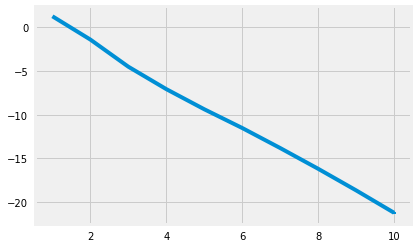

In [16]:
plt.errorbar(
    x=results_.groupby(['spatial']).mean().index, 
    y=results_.groupby(['spatial']).mean()['h_cmip'], 
    yerr=results_.groupby(['spatial']).std()['h_cmip']
)

### Total Correlation

In [17]:
def plot_global_tc(results_df: pd.DataFrame, base: str, cmip: str)-> None:
    results_df = results_df[results_df['base'] == base]
    results_df = results_df[results_df['cmip'] == cmip]
    sns.scatterplot(data=results_df, x='spatial', y='tc_base', label=f"{base}")
    sns.scatterplot(data=results_df, x='spatial', y='tc_cmip', label=f"{cmip}")
    plt.title(f'{base.upper()}, CMIP: {cmip.upper()}')
    plt.xlabel('Spatial Features')
    plt.ylabel('Total Correlation, TC')
    plt.legend()
    plt.show()

No handles with labels found to put in legend.


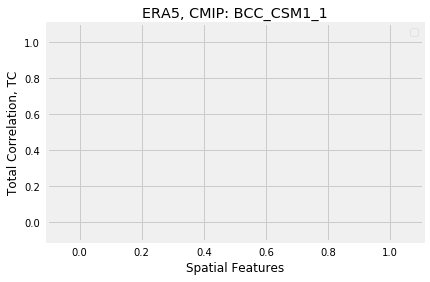

No handles with labels found to put in legend.


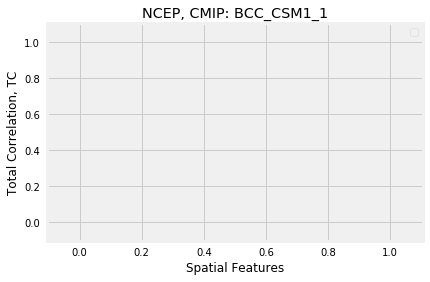

In [18]:
plot_global_tc(results, 'era5', 'bcc_csm1_1')
plot_global_tc(results, 'ncep', 'bcc_csm1_1')

In [19]:
def plot_global_diff_tc(results_df: pd.DataFrame, base: str, normalized=True)-> None:
    
    
    results_copy = results_df[results_df['base'] == base]
    
    # calculate difference
    results_copy['tc_diff'] = np.abs(results_copy['tc_cmip'] - results_copy['tc_base'])
        
    if normalized == True:
        results_copy['tc_diff'] = results_copy['tc_diff'] / results_copy['spatial']
    
    
    fig, ax = plt.subplots()
#     sns.scatterplot(ax=ax, data=results_copy, x='spatial', y='h_diff', hue='base', color='black')
    sns.scatterplot(ax=ax, data=results_copy, x='spatial', y='tc_diff', hue='cmip')
        
    plt.title(f'')
    plt.xlabel('Spatial Features')
    plt.ylabel('Total Correlation, TC')
    plt.legend(ncol=2, bbox_to_anchor=(2.05, 1), fontsize=16)
#     plt.tight_layout()
    plt.show()

/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


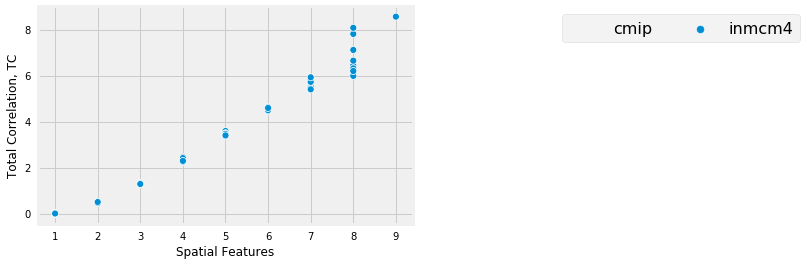

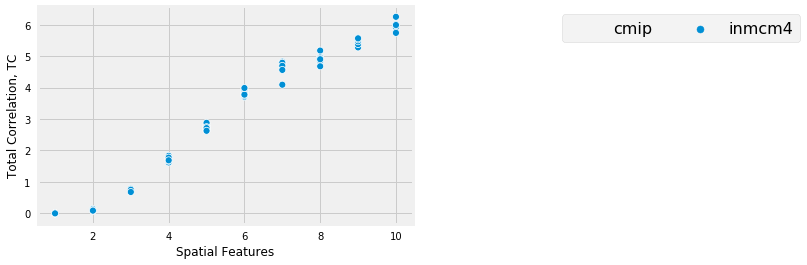

In [20]:
plot_global_diff_tc(results, 'era5', normalized=True)
plot_global_diff_tc(results, 'ncep', normalized=True)

### Mutual Information

In [116]:
from pathlib import Path
data_path = f"/home/emmanuel/projects/projects/2020_rbig_rs/data/climate/results/amip/local/compare/"

def get_results_files(base_model: str, trials: bool)-> pd.DataFrame:
    
    path = Path(data_path)
    
    if base_model == 'ncep':
        base_pattern = 'ncep'
        
    elif base_model == 'era5':
        base_pattern = 'era5'
        
    else:
        raise ValueError('Unrecognized base model:', base_model)
    
    if trials == True:
        trials_ext = 'v1'
    elif trials == False:
        trials_ext = 'v2'
    else:
        raise ValueError("Unrecognized trials extentions:", trials)
    
    filename_pattern = base_pattern + '*' + trials_ext + '.csv'
#     [print(f) for f in path.rglob(filename_pattern)]
#     [print(pd.read_csv(f, index_col=0).columns.shape) for f in path.rglob(filename_pattern)]
    df_from_each_file = [pd.read_csv(f, index_col=0) for f in path.rglob(filename_pattern)]
    results_df   = pd.concat(df_from_each_file, ignore_index=True)
    return results_df

def post_processing_compare(df: pd.DataFrame)-> pd.DataFrame:
    
    # divide by the spatial resolution
    df['mi'] = df['mi'] / (df['spatial'] ** 2)
    
    return df

In [135]:
data_path = f"/home/emmanuel/projects/2020_rbig_rs/data/climate/results/amip/global/compare/"

results_df = get_results_files('ncep', True)
results_df.head()

,base,cmip,kendelltau,mi,pearson,spatial,spearman,subsample,time_mi,trial,variable
0,ncep,ipsl_cm5a_lr,0.003626,0.000000,-0.001851,1.0,0.005446,50000.0,5.857332,0.0,psl
1,ncep,ipsl_cm5a_lr,0.002938,0.002368,0.007819,1.0,0.004426,50000.0,6.268424,1.0,psl
2,ncep,ipsl_cm5a_lr,-0.000549,0.000000,0.000828,1.0,-0.000812,50000.0,5.914340,2.0,psl
3,ncep,ipsl_cm5a_lr,0.001832,0.000000,0.001873,1.0,0.002766,50000.0,5.903604,3.0,psl
4,ncep,ipsl_cm5a_lr,0.009921,0.002683,0.011140,1.0,0.014819,50000.0,5.907503,4.0,psl


In [136]:
def plot_global_mi(results_df: pd.DataFrame, base: str, cmip: str, measure='mi', normalized=True)-> None:
    
    results_df = results_df[results_df['base'] == base]
    results_df = results_df[results_df['cmip'] == cmip]
    
    if normalized and measure == 'mi':
        results_df[measure] = results_df[measure] / results_df['spatial']
    sns.scatterplot(data=results_df, x='spatial', y=measure, label=f"{base}")
    sns.scatterplot(data=results_df, x='spatial', y=measure, label=f"{cmip}")
    plt.title(f'{base.upper()}, CMIP: {cmip.upper()}')
    plt.xlabel('Spatial Features')
    plt.ylabel(f'{measure.upper()}')
    plt.legend()
    plt.show()

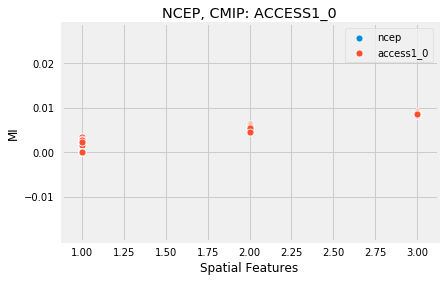

In [138]:
plot_global_mi(results_df, 'ncep', 'access1_0', 'mi')
# plot_global_mi(results_df, 'era5', 'noresm1_m', 'pearson')
# plot_global_mi(results_df, 'era5', 'noresm1_m', 'spearman')
# plot_global_mi(results_df, 'era5', 'noresm1_m', 'kendelltau')

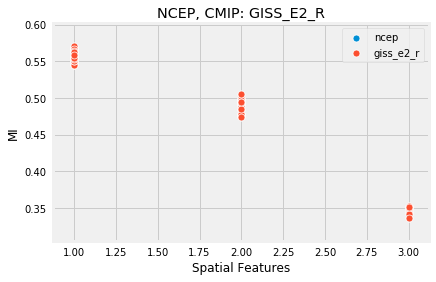

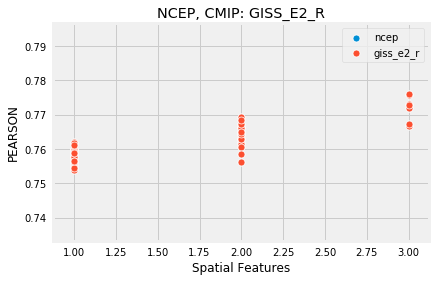

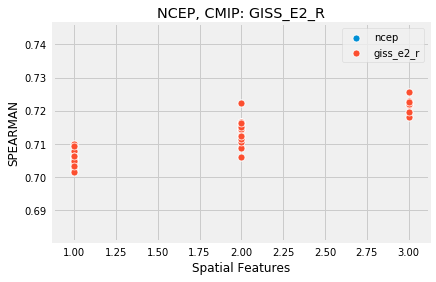

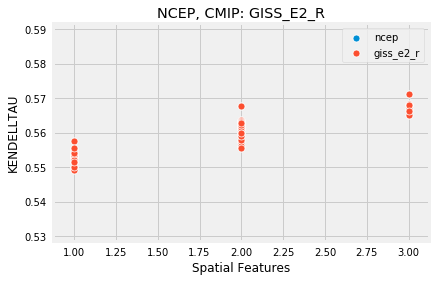

In [140]:
plot_global_mi(results_df, 'ncep', 'giss_e2_r', 'mi')
plot_global_mi(results_df, 'ncep', 'giss_e2_r', 'pearson')
plot_global_mi(results_df, 'ncep', 'giss_e2_r', 'spearman')
plot_global_mi(results_df, 'ncep', 'giss_e2_r', 'kendelltau')

In [123]:
def plot_global_diff_mi(results_df: pd.DataFrame, base: str, measure='mi', normalized=True, log_mi=True)-> None:
    
    
    results_copy = results_df[results_df['base'] == base]
    
        
    if normalized == True:
        results_copy[measure] = results_copy[measure] / results_copy['spatial']
    
    if log_mi == True and measure == 'mi':
        results_copy[measure] = np.log(results_copy[measure])
    
    fig, ax = plt.subplots()
#     sns.scatterplot(ax=ax, data=results_copy, x='spatial', y='h_diff', hue='base', color='black')
    sns.scatterplot(ax=ax, data=results_copy, x='spatial', y=measure, hue='cmip')
        
    plt.title(f'')
    plt.xlabel('Spatial Features')
    plt.ylabel(f'{measure.upper()}')
    plt.legend(ncol=2, bbox_to_anchor=(2.05, 1), fontsize=16)
#     plt.tight_layout()
    plt.show()

In [ ]:
giss_e2_r

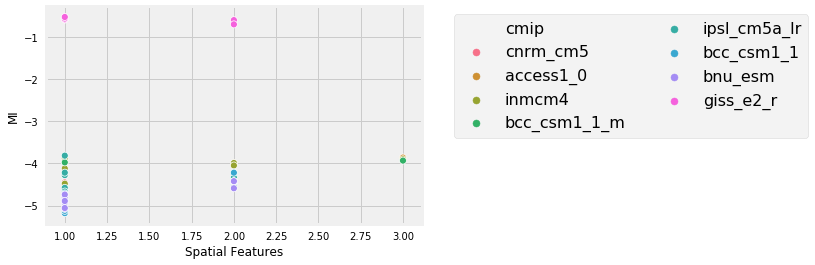

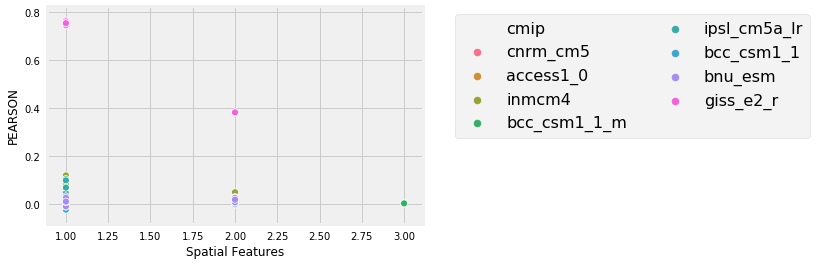

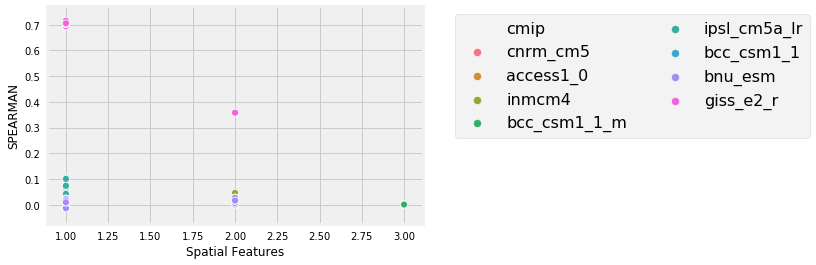

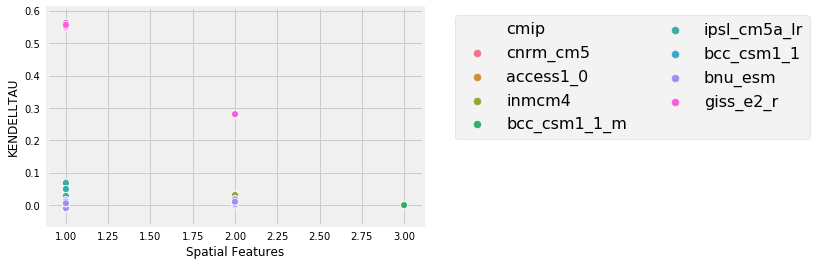

In [134]:
plot_global_diff_mi(results_df, 'ncep', 'mi', True, True)
plot_global_diff_mi(results_df, 'ncep', 'pearson', True, True)
plot_global_diff_mi(results_df, 'ncep', 'spearman', True, True)
plot_global_diff_mi(results_df, 'ncep', 'kendelltau', True, True)